In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings('ignore')

In [14]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Data Preprocessing For Training dataset


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  object 
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  object 
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               13590 non-null  float64
 12  composts_organic_w

In [16]:
# handling missing values

for col in train_df.columns:
    if train_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(train_df[col]):
            median_val = train_df[col].median()
            train_df[col].fillna(median_val, inplace=True)
        else:
            mode_val = train_df[col].mode()[0]
            train_df[col].fillna(mode_val, inplace=True)

In [20]:
# Convert Datatype object ---> float64

train_df['house_area_sqft'] = pd.to_numeric(train_df['house_area_sqft'], errors='coerce')
median_house_area = train_df['house_area_sqft'].median()
train_df['house_area_sqft'].fillna(median_house_area, inplace=True)
train_df['house_area_sqft'] = train_df['house_area_sqft'].astype('float64')


In [21]:
# Convert Datatype object ---> int64

train_df['household_size'] = pd.to_numeric(train_df['household_size'], errors='coerce')
median_household_size = train_df['household_size'].median()
train_df['household_size'].fillna(median_household_size, inplace=True)
train_df['household_size'] = train_df['household_size'].astype('int64')


In [22]:
train_df

,ID,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,recycles_regularly,composts_organic_waste,uses_solar_panels,energy_efficient_appliances,heating_type,diet_type,owns_pet,smart_thermostat_installed,carbon_footprint
0,0xd6c,759.70,55.95,944.55,2422.07,541.27,1,3,2,4.23,9,1.0,0.0,0,1.0,gas,vegetarian,1,0.0,830.10
1,0x3fdf,387.06,70.59,1280.85,1995.30,280.39,1,2,1,3.27,8,0.0,0.0,0,0.0,electric,vegetarian,0,0.0,963.08
2,0x3b08,594.25,29.14,1005.72,2673.55,416.14,0,2,3,2.87,3,0.0,1.0,0,1.0,electric,omnivore,1,1.0,840.11
3,0x31e5,503.76,74.68,1049.46,2994.28,530.13,0,5,1,3.22,9,1.0,0.0,0,0.0,electric,omnivore,1,0.0,1252.42
4,0x397e,549.54,-77.00,756.49,2549.57,604.10,5,4,4,2.92,2,1.0,0.0,0,1.0,electric,vegetarian,0,1.0,580.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0x4aaa,324.96,43.37,438.36,1514.05,419.48,3,1,2,3.17,7,0.0,0.0,0,0.0,electric,omnivore,1,1.0,865.07
13996,0x36c3,581.19,83.50,1865.29,3357.90,651.11,0,1,3,6.60,3,1.0,1.0,0,0.0,gas,omnivore,1,0.0,1594.70
13997,0x3846,302.76,43.36,212.42,939.08,343.67,9,1,2,3.07,3,1.0,0.0,1,0.0,gas,omnivore,1,1.0,712.94
13998,0x4ba4,397.77,14.80,592.66,1164.04,271.67,2,7,0,2.48,4,1.0,0.0,1,0.0,gas,vegetarian,0,0.0,533.65


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  float64
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  int64  
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               14000 non-null  float64
 12  composts_organic_w

In [29]:

for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        print(f"Column '{col}' contains non-numeric data.")
        print(train_df[col].unique())


Column 'ID' contains non-numeric data.
['0xd6c' '0x3fdf' '0x3b08' ... '0x3846' '0x4ba4' '0x2dc0']
Column 'heating_type' contains non-numeric data.
['gas' 'electric' 'none']
Column 'diet_type' contains non-numeric data.
['vegetarian' 'omnivore' 'vegan']


In [30]:
# Handling Garbage Values

valid_heating = ['gas', 'electric', 'none']

def clean_heating_type(col):
    mode_val = col[col.isin(valid_heating)].mode()
    if not mode_val.empty:
      mode_val = mode_val[0]
    else:
      mode_val = 'gas'
    return col.apply(lambda x: x if x in valid_heating else mode_val)

train_df['heating_type'] = clean_heating_type(train_df['heating_type'])


In [31]:
# Transform categorical Data (Text or Categories) ---> numerical Data

train_df = pd.get_dummies(train_df, columns=['heating_type', 'diet_type'])

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  float64
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  int64  
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               14000 non-null  float64
 12  composts_organic_w

In [33]:
# Converting Boolean Columns to Integers

for col in train_df.columns:
    if train_df[col].dtype == 'bool':
        train_df[col] = train_df[col].astype(int)

In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14000 non-null  object 
 1   electricity_kwh_per_month        14000 non-null  float64
 2   natural_gas_therms_per_month     14000 non-null  float64
 3   vehicle_miles_per_month          14000 non-null  float64
 4   house_area_sqft                  14000 non-null  float64
 5   water_usage_liters_per_day       14000 non-null  float64
 6   public_transport_usage_per_week  14000 non-null  int64  
 7   household_size                   14000 non-null  int64  
 8   home_insulation_quality          14000 non-null  int64  
 9   meat_consumption_kg_per_week     14000 non-null  float64
 10  laundry_loads_per_week           14000 non-null  int64  
 11  recycles_regularly               14000 non-null  float64
 12  composts_organic_w

In [58]:
# Drop ID column
train_df = train_df.drop('ID',axis=1)

# Data Preprocessing for Testing Dataset

In [37]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               6000 non-null   object 
 1   electricity_kwh_per_month        6000 non-null   float64
 2   natural_gas_therms_per_month     6000 non-null   float64
 3   vehicle_miles_per_month          6000 non-null   float64
 4   house_area_sqft                  6000 non-null   object 
 5   water_usage_liters_per_day       6000 non-null   float64
 6   public_transport_usage_per_week  6000 non-null   int64  
 7   household_size                   6000 non-null   object 
 8   home_insulation_quality          6000 non-null   int64  
 9   meat_consumption_kg_per_week     6000 non-null   float64
 10  laundry_loads_per_week           6000 non-null   int64  
 11  recycles_regularly               5821 non-null   float64
 12  composts_organic_was

In [38]:
# Handling Missing Values

for col in test_df.columns:
    if test_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(test_df[col]):
            median_val = test_df[col].median()
            test_df[col].fillna(median_val, inplace=True)
        else:
            mode_val = test_df[col].mode()[0]
            test_df[col].fillna(mode_val, inplace=True)


In [39]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               6000 non-null   object 
 1   electricity_kwh_per_month        6000 non-null   float64
 2   natural_gas_therms_per_month     6000 non-null   float64
 3   vehicle_miles_per_month          6000 non-null   float64
 4   house_area_sqft                  6000 non-null   object 
 5   water_usage_liters_per_day       6000 non-null   float64
 6   public_transport_usage_per_week  6000 non-null   int64  
 7   household_size                   6000 non-null   object 
 8   home_insulation_quality          6000 non-null   int64  
 9   meat_consumption_kg_per_week     6000 non-null   float64
 10  laundry_loads_per_week           6000 non-null   int64  
 11  recycles_regularly               6000 non-null   float64
 12  composts_organic_was

In [42]:
# Convert datatype object ---> float64

test_df['house_area_sqft'] = pd.to_numeric(test_df['house_area_sqft'], errors='coerce')
median_house_area = test_df['house_area_sqft'].median()
test_df['house_area_sqft'].fillna(median_house_area, inplace=True)
test_df['house_area_sqft'] = test_df['house_area_sqft'].astype('float64')

In [43]:
# Convert datatype object ---> int64

test_df['household_size'] = pd.to_numeric(test_df['household_size'], errors='coerce')
median_household_size = test_df['household_size'].median()
test_df['household_size'].fillna(median_household_size, inplace=True)
test_df['household_size'] = test_df['household_size'].astype('int64')


In [45]:

for col in test_df.columns:
    if not pd.api.types.is_numeric_dtype(test_df[col]):
        print(f"Column '{col}' contains non-numeric data.")
        print(test_df[col].unique())


Column 'ID' contains non-numeric data.
['0x42e7' '0x1950' '0x20e5' ... '0x4b6' '0x4d5a' '0x2e01']
Column 'heating_type' contains non-numeric data.
['gas' 'electric' 'none' ';[8K4' ']LY1Z' 'gaPz.' '1<eyv' '7BlEh' '>n>@Q'
 "4D,'n" 'RLBws' 'iE=T,' 'TdlM8' '~$n@O' 'bJ01:' 'Y>sV)' '&=|6J' '_e@vJ'
 'B(1TG' ')H(tC' '-g+r~' 'Re0O[' 'W"J7J' '/}*[e' '9jt@:' 'N!YiN' '`(pPA'
 '^4wc6' 'R"[tX' 'Ei;b~' ':{7]t' 'PX_XH' 'SAO@,' 'N~Amu' '-O/(p' 'I%TIs'
 '9/[EX' 'VI&qU' 'sR^v$' ']Bd5i' 'frS|e' 'msXXE' 'PNqm<' 'z#{r0' 'tE"hY'
 'z8>yv' 'Q,?K%' ',~yyn' '0J!D3' '8]PgQ' '+xL:K' 'm2U~H' 'Y(n~7' '=!Mvv'
 '\\\\tZa' 'm]6Hg' 'c5_xc' '.@L)8' 'fq}8i' 'tIPMC' '{58^r' 'N<=>;' ':8i8d'
 'OiE%m' ')rhaO' '7iT@v' 'uXj%_' '>.mE#' 'iE+i8' '!h|L{' 'h:L9z' 'fPgZM'
 '5mov8' 'J~|bE' 'V8of7' '~MF#K' 'OJ|i+' '<H,|q' 'C+[Rk' 'h6LM,' ':Ebv6'
 'efCtx' '5dru|' '?>jN!' '3:"Fe' '1#H|L' 'jt%9l' '1uNm`' '.~1hF' '5b[W?'
 'AV%,z' "M'_51" 'W|s]h' 'Se2K<' '`/Suy' 'V#hX^' 'rd@7M' 'AlX~_' '{c+~v'
 'A:enG' 'M~y\\7' 'u10X6' 'rjqT(' 'vK$Qx' "&FoJ'

In [46]:
# Handling Garbage Values

valid_heating = ['gas', 'electric', 'none']

def clean_heating_type(col):
    mode_val = col[col.isin(valid_heating)].mode()
    if not mode_val.empty:
      mode_val = mode_val[0]
    else:
      mode_val = 'gas'
    return col.apply(lambda x: x if x in valid_heating else mode_val)

test_df['heating_type'] = clean_heating_type(test_df['heating_type'])

In [48]:
# Transform categorical Data (Text or Categories) ---> numerical Data

test_df = pd.get_dummies(test_df, columns=['heating_type', 'diet_type'])

In [49]:
for col in test_df.columns:
    if test_df[col].dtype == 'bool':
        test_df[col] = test_df[col].astype(int)

In [50]:
# Drop ID column
test_ids = test_df['ID']
test_X = test_df.drop(['ID'], axis=1)

In [51]:
test_X

,electricity_kwh_per_month,natural_gas_therms_per_month,vehicle_miles_per_month,house_area_sqft,water_usage_liters_per_day,public_transport_usage_per_week,household_size,home_insulation_quality,meat_consumption_kg_per_week,laundry_loads_per_week,...,uses_solar_panels,energy_efficient_appliances,owns_pet,smart_thermostat_installed,heating_type_electric,heating_type_gas,heating_type_none,diet_type_omnivore,diet_type_vegan,diet_type_vegetarian
0,309.73,58.89,984.73,1790.96,332.68,3,5,3,1.86,2,...,0,1.0,0,0.0,0,1,0,0,0,1
1,278.49,48.47,841.76,1523.78,443.22,8,3,4,2.33,5,...,0,1.0,0,0.0,1,0,0,1,0,0
2,404.12,33.59,1219.33,1187.35,303.94,2,2,2,3.23,2,...,0,0.0,0,0.0,0,1,0,1,0,0
3,324.74,41.93,562.96,647.43,496.58,2,1,3,4.01,7,...,1,1.0,1,0.0,1,0,0,1,0,0
4,397.75,52.13,690.82,1576.17,346.56,0,5,4,2.23,6,...,0,0.0,0,0.0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,422.80,56.70,428.54,1664.57,388.23,4,2,3,4.38,8,...,0,0.0,1,0.0,0,0,1,1,0,0
5996,423.90,58.47,906.81,2057.72,420.22,1,7,2,3.43,5,...,0,0.0,0,0.0,0,1,0,1,0,0
5997,440.94,44.60,1293.12,917.63,402.39,1,3,2,3.39,9,...,0,1.0,0,0.0,0,1,0,1,0,0
5998,403.28,45.78,794.25,1784.37,495.33,2,3,1,2.39,2,...,0,1.0,1,0.0,1,0,0,1,0,0


# Train the Model ( Hyperparameter Optmization + XGBoosting )

In [59]:
# Separate target variable from features in the training data
X_train = train_df.drop('carbon_footprint', axis=1)
y_train = train_df['carbon_footprint']

# Features (X) for the test set
X_test = test_X

In [60]:

# Hyperparameter Optimization using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(500, 2000),
    'learning_rate': uniform(0.01, 0.3),  # Adjust the range as needed
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 10),
    'min_child_weight': randint(1, 10)

}

# Initialize XGBRegressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True, tree_method='hist', random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='r2',  # Use R-squared as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    cv=5,  # Use 5-fold cross-validation
    verbose=2,  # Print progress updates
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_xgb_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'colsample_bytree': np.float64(0.795446471594121), 'gamma': np.float64(6.775643618422825), 'learning_rate': np.float64(0.014976348678356847), 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 1671, 'subsample': np.float64(0.822586395204725)}


# Making Predictions and Evaluating the Model

In [61]:
# Use the best model to make predictions
test_preds = best_xgb_model.predict(X_test)

submission = pd.DataFrame({
    'ID': test_ids,
    'carbon_footprint': test_preds
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

val_preds = best_xgb_model.predict(X_train)
score = max(0, 100 * r2_score(y_train, val_preds))
print(f"Validation R² Score: {score:.2f}")

Submission file saved as submission.csv
Validation R² Score: 94.40


# Visualizing Carbon Footprint Distribution


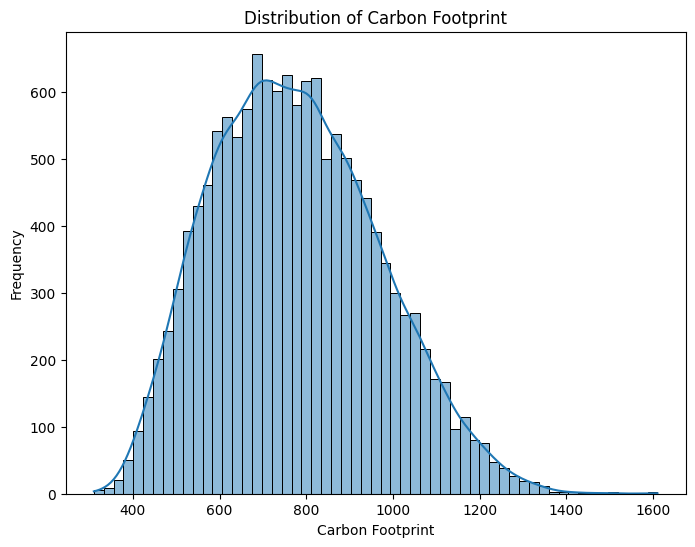

In [64]:
# Example 1: Distribution of 'carbon_footprint'
plt.figure(figsize=(8, 6))
sns.histplot(train_df['carbon_footprint'], kde=True)
plt.title('Distribution of Carbon Footprint')
plt.xlabel('Carbon Footprint')
plt.ylabel('Frequency')
plt.show()

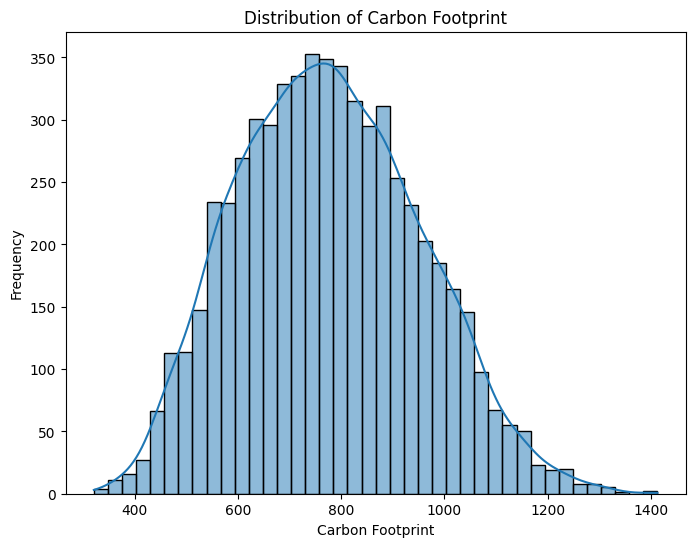

In [63]:
# Example 1: Distribution of 'carbon_footprint'
plt.figure(figsize=(8, 6))
sns.histplot(submission['carbon_footprint'], kde=True)
plt.title('Distribution of Carbon Footprint')
plt.xlabel('Carbon Footprint')
plt.ylabel('Frequency')
plt.show()